# GAIA DR2 -- Parallax regeneration notebook


In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib notebook
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib notebook

In [3]:
data_master = pd.read_csv('/bigdata1/gaia/dr2_clean.csv').iloc[:,2:]
data_master.shape

(2000000, 22)

In [4]:
def plot_gaia(data, markersize=0.04, title='', sample_size=10000, max_parallax=20):

    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12*.8,9*.8))

    data['DeepGaia parallax'].sample(sample_size).plot(kind='hist', bins=800, ax=ax[0,0], label='DeepGaia parallax', alpha=0.4, normed=True, color='r')
    data.parallax.sample(sample_size).plot( kind='hist', bins=800, ax=ax[0,0], label='Observed parallax',  alpha=0.4, normed=True, color='darkblue')
    ax[0,0].legend(fontsize=10, frameon=False); ax[0,0].set_xlim(-1,15);

    data.sample(sample_size).plot(kind='scatter', ax=ax[0,1], x='parallax', y='DeepGaia parallax', s=markersize, c='bp_rp', cmap='viridis', vmin=0, vmax=4)
    ax[0,1].plot([-20,20],[-20,20], ls='--', lw=0.7, color='k'); 
    ax[0,1].set_xlim(-3, 20); ax[0,1].set_ylim(-3,20)

    data.sample(sample_size).plot(kind='scatter', ax=ax[1,0], x='bp_rp', y='ABS G observed', s=markersize, label='Gaia parallax', 
                                  c='parallax', cmap='viridis', vmin=0, vmax=max_parallax)
    ax[1,0].set_ylim(18, -6); ax[1,0].set_xlim(-1, 5)

    data.sample(sample_size).plot(kind='scatter', ax=ax[1,1], x='bp_rp', y='ABS G DeepGaia', s=markersize, label='Model parallax', 
                                  c='DeepGaia parallax', cmap='viridis', vmin=0, vmax=max_parallax)
    ax[1,1].set_ylim(18, -6); ax[1,1].set_xlim(-1, 5)

    for axes in ax:
        for axax in axes:
            axax.grid(alpha=0.1)

    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [5]:
class Net(torch.nn.Module):
    def __init__(self, num_input, n_layers=5, n_nodes=70):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(num_input, n_nodes)
        self.fc_middle = torch.nn.ModuleList(
            [torch.nn.Linear(n_nodes, n_nodes) for _ in range(n_layers)]
        )
        self.fc_before_middles = torch.nn.ModuleList(
            [torch.nn.Linear(n_nodes, n_nodes) for _ in range(n_layers - 1)]
        )
        self.fc_before_out = torch.nn.Linear(n_nodes, 2)
        self.fc_before_before_out = torch.nn.Linear(n_nodes, 2)
        self.n_layers = n_layers

    def forward(self, x):
        # Max pooling over a (2, 2) window
        activation = F.leaky_relu
        input_vec = x
        x = activation(self.fc1(x))
        network_input = x
        x = activation(self.fc_middle[0](x))

        for i in range(1, self.n_layers):
            x = activation(self.fc_middle[i](x) + self.fc_before_middles[i - 1](network_input))

        go_into_last = self.fc_before_before_out(network_input)
        x = self.fc_before_out(x)
        x = x + go_into_last
        
        return x

In [6]:
def train_model(model, data_train, features, targets, num_epochs=1000, loss_type='gaussian_assumption'):
    
    X = data_train[features]
    y = data_train[targets]

    xmeans = X.mean()
    xstds  = X.std()
    X -= xmeans
    X /= xstds

    ymean = y.mean()
    ystd  = y.std()
    y -= ymean
    y /= ystd

    X = Variable(torch.from_numpy(X.values).type(torch.FloatTensor)).cuda()
    y = Variable(torch.from_numpy(y.values).type(torch.FloatTensor)).cuda().view(-1)
    
    solver = torch.optim.Adamax(model.parameters(), lr=1.0e-2)
    
    if loss_type == 'gaussian_assumption':
        criteria = torch.nn.MSELoss(reduction='none')
    else:
        criteria = torch.nn.SmoothL1Loss(reduction='none')
        
    training_loss = []
    
    for it in tqdm(range(num_epochs)):
        model_output = model(X)
        
        if loss_type == 'gaussian_assumption':
            loss = (criteria(model_output[:,0], y) / (0.01 + torch.abs(model_output[:,1]))**2 + torch.log(0.01 + torch.abs(model_output[:,1]))).sum()
        else:
            loss = criteria(model_output[:,0], y).sum()
            
        loss.backward()
        solver.step()
        model.zero_grad()
        training_loss.append(loss.data)
    
    model_output = model(X).data.cpu().numpy()[:,0]
    parallax2 = model_output.flatten()
    parallax2 = parallax2*ystd[0] + ymean[0]

    data_train['DeepGaia parallax'] =  parallax2
    data_train['ABS G observed']    = data_train.phot_g_mean_mag - 5*np.log10(1000./data_train.parallax)  + 5.
    data_train['ABS G DeepGaia']    = data_train.phot_g_mean_mag - 5*np.log10(1000./data_train['DeepGaia parallax']) + 5.
    
    training_loss = pd.Series([x.cpu().numpy().mean() for x in training_loss])
    fig, ax = plt.subplots(figsize=(5,3))
    training_loss.plot(lw=0.7, label='training loss', color='darkred')
    ax.grid(alpha=0.1)
    
    return model, data_train, training_loss

In [7]:
def deep_gaia(data_master, n_layers, n_nodes, n_epochs, n_samples, loss_type='gaussian_assumption'):
    
    data_train = pd.DataFrame.copy(data_master).sample(n_samples)
    targets  = ['parallax']
#     features = [x for x in data_train.columns if x not in targets and x != 'parallax_over_error']

    features = ['ra',
     'dec',
     'pmra',
     'pmdec',
     'phot_g_mean_mag',
#      'phot_bp_mean_mag',
#      'phot_rp_mean_mag',
     'bp_rp',
     'bp_g',
     'g_rp']

    print('--------------- DeepGAIA ---------------')
    print('')
    print('Number of samples used for training: {}'.format(data_train.shape[0]))
    print('')
    print('Features being used for DeepGAIA: {}'.format(features))

    model = Net(num_input=len(features), n_layers=n_layers, n_nodes=n_nodes).cuda()
    model, data_train, training_loss = train_model(model, data_train, features, targets, num_epochs=n_epochs, loss_type=loss_type)  
    
    return model, data_train

--------------- DeepGAIA ---------------

Number of samples used for training: 300000

Features being used for DeepGAIA: ['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'bp_rp', 'bp_g', 'g_rp']


<IPython.core.display.Javascript object>


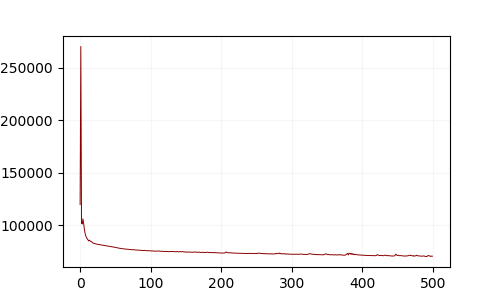

<IPython.core.display.Javascript object>


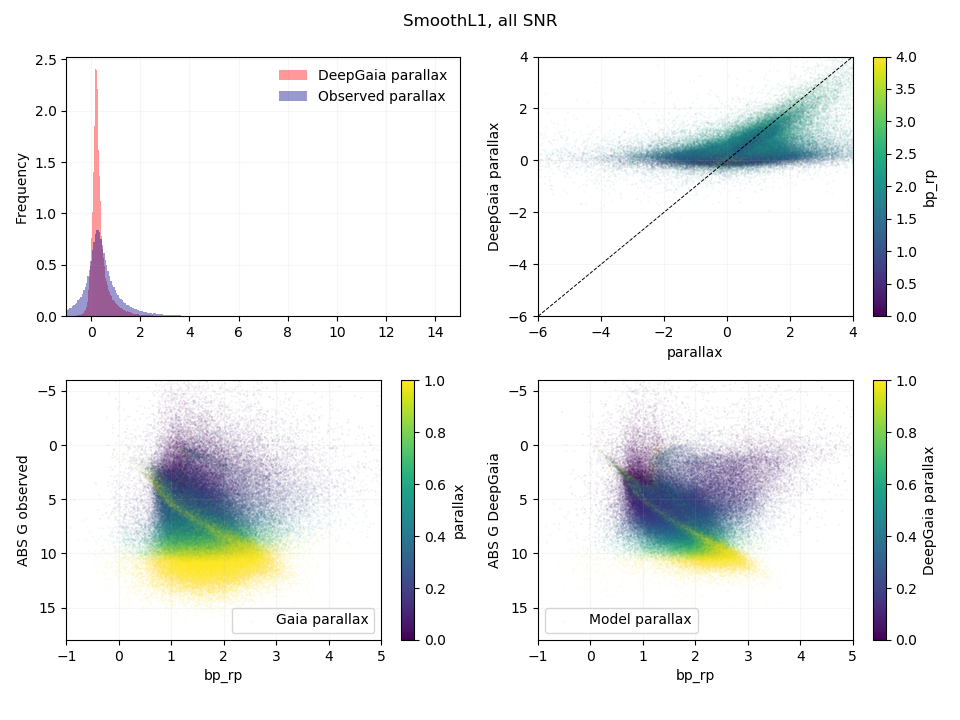

CPU times: user 1min 10s, sys: 29.7 s, total: 1min 40s
Wall time: 1min 33s


In [11]:
%%time

loss_type='SmoothL1'

model, data_train = deep_gaia(data_master, n_layers=10, n_nodes=100, n_epochs=500, 
                              n_samples=300000, loss_type=loss_type)

plot_gaia(data_train, 
          sample_size=data_train.shape[0], 
          markersize=0.001, title='{}, all SNR'.format(loss_type), 
          max_parallax=1)

--------------- DeepGAIA ---------------

Number of samples used for training: 1000000

Features being used for DeepGAIA: ['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'bp_rp', 'bp_g', 'g_rp']


<IPython.core.display.Javascript object>


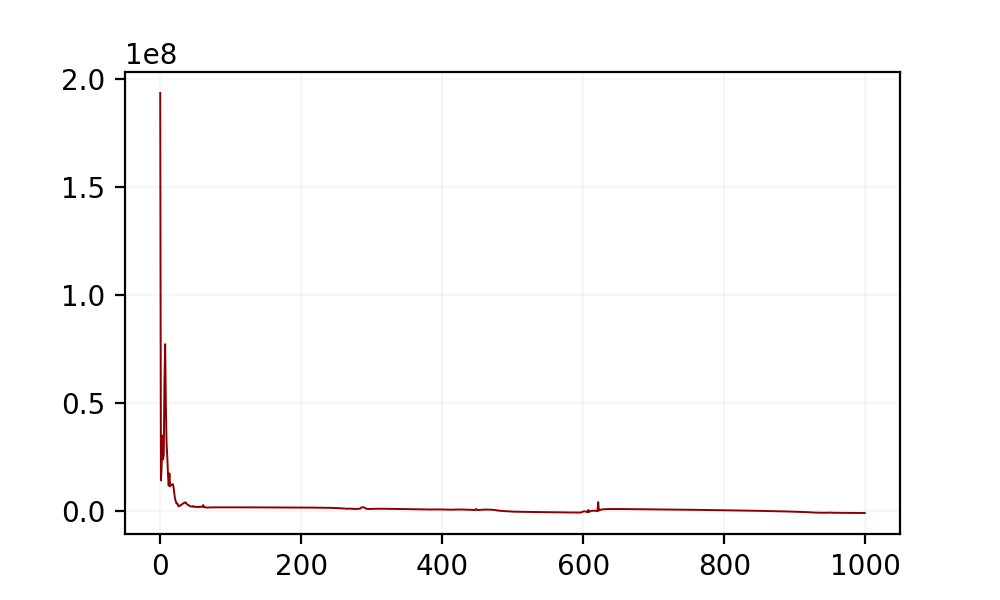

<IPython.core.display.Javascript object>


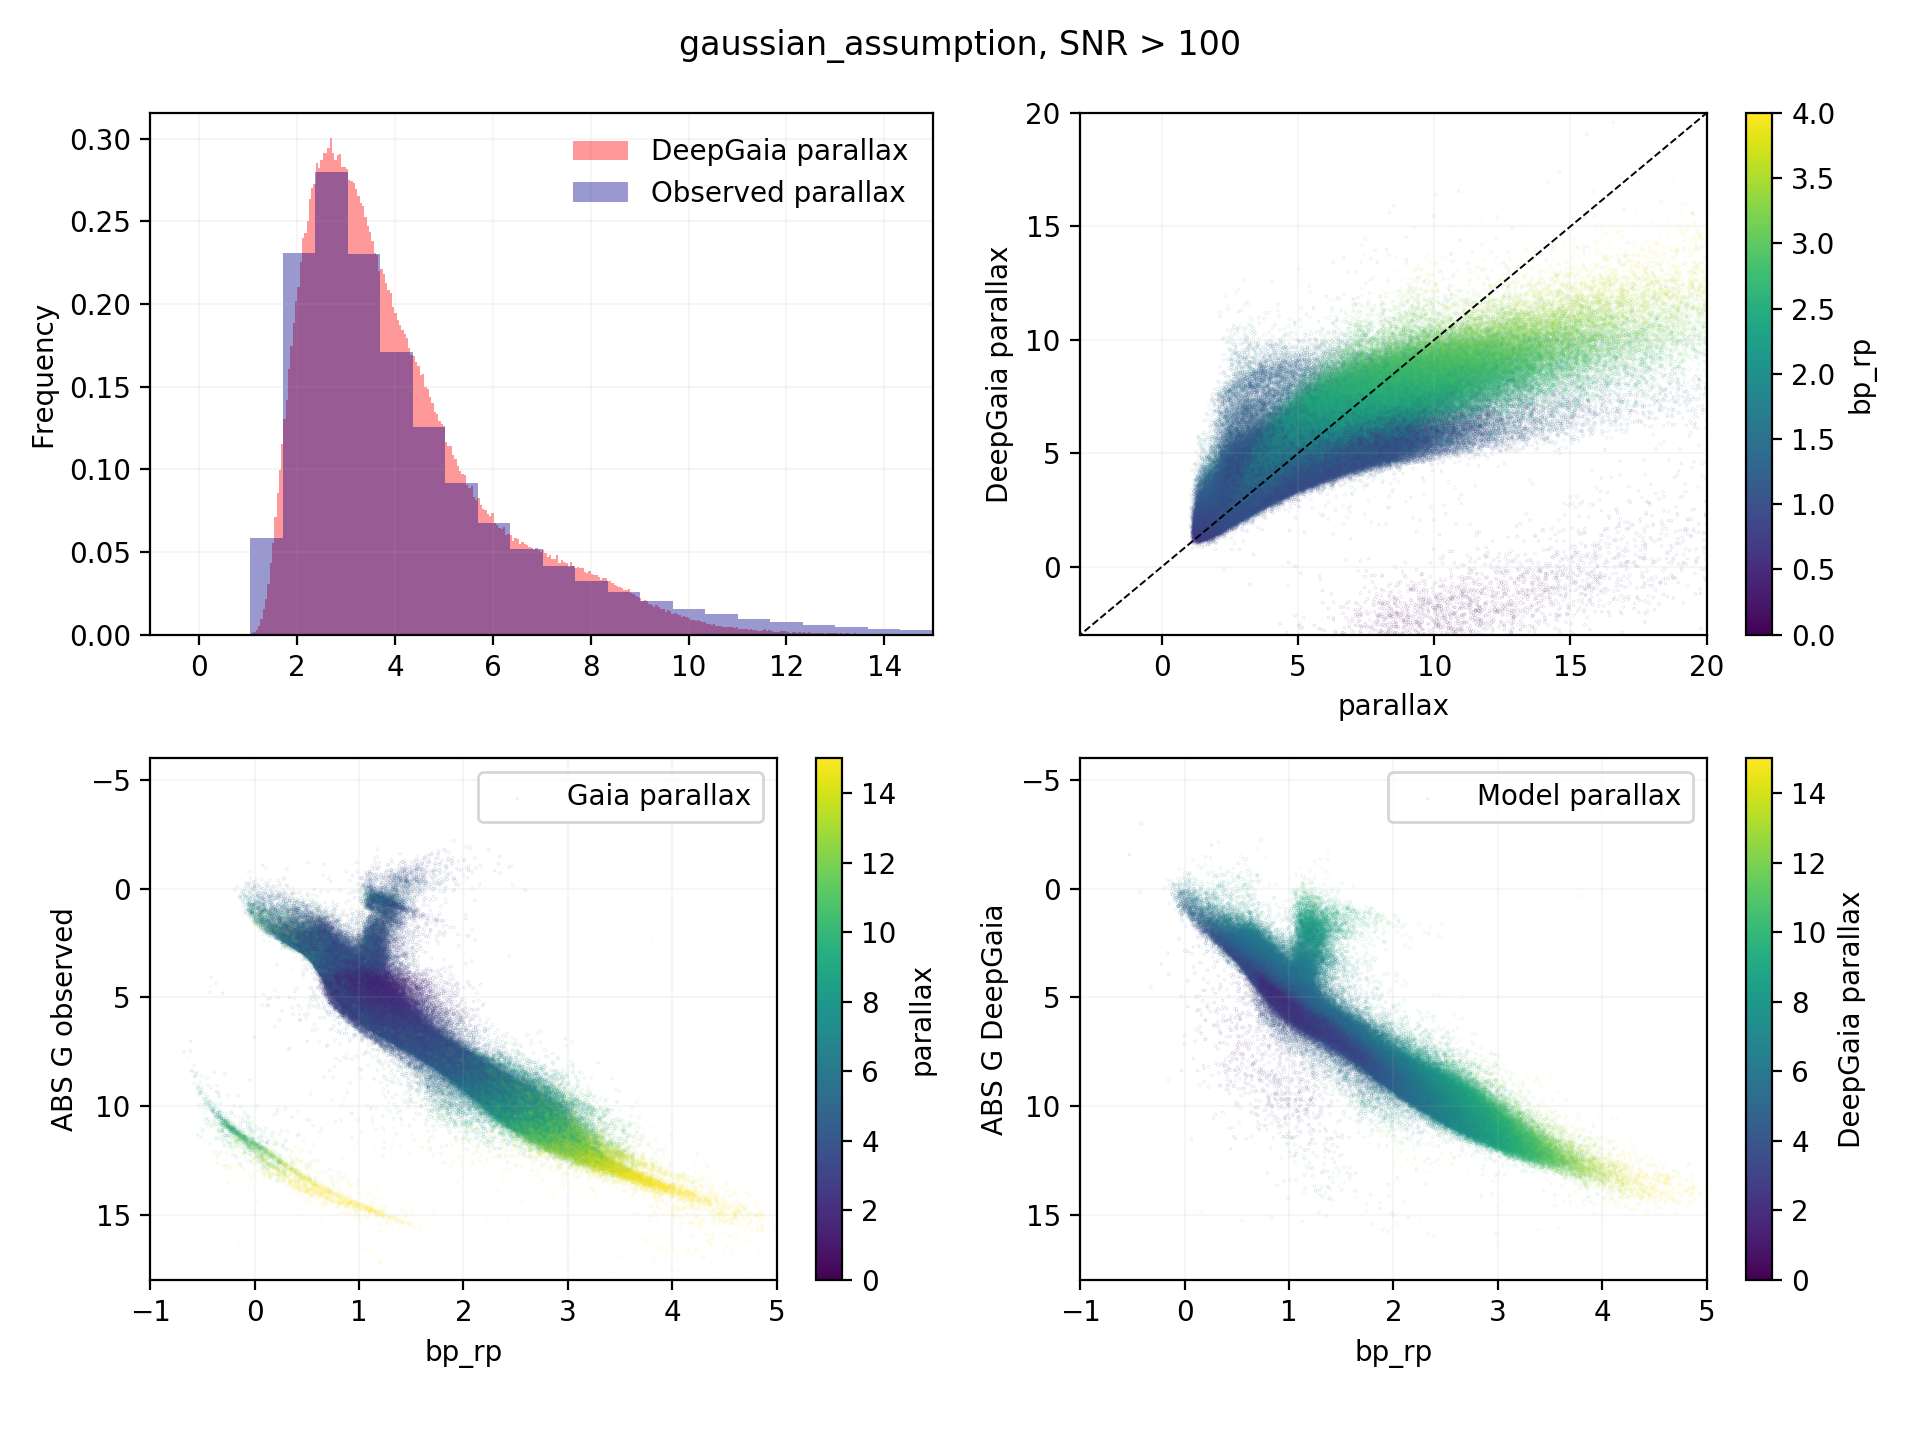

CPU times: user 7min 25s, sys: 2min 56s, total: 10min 22s
Wall time: 10min 14s


In [8]:
%%time

loss_type='gaussian_assumption'

model, data_train = deep_gaia(data_master, n_layers=10, n_nodes=100, n_epochs=1000, 
                              n_samples=1000000, loss_type=loss_type)

plot_gaia(data_train, 
          sample_size=data_train.shape[0], 
          markersize=0.001, title='{}, SNR > 100'.format(loss_type), 
          max_parallax=15)

<IPython.core.display.Javascript object>


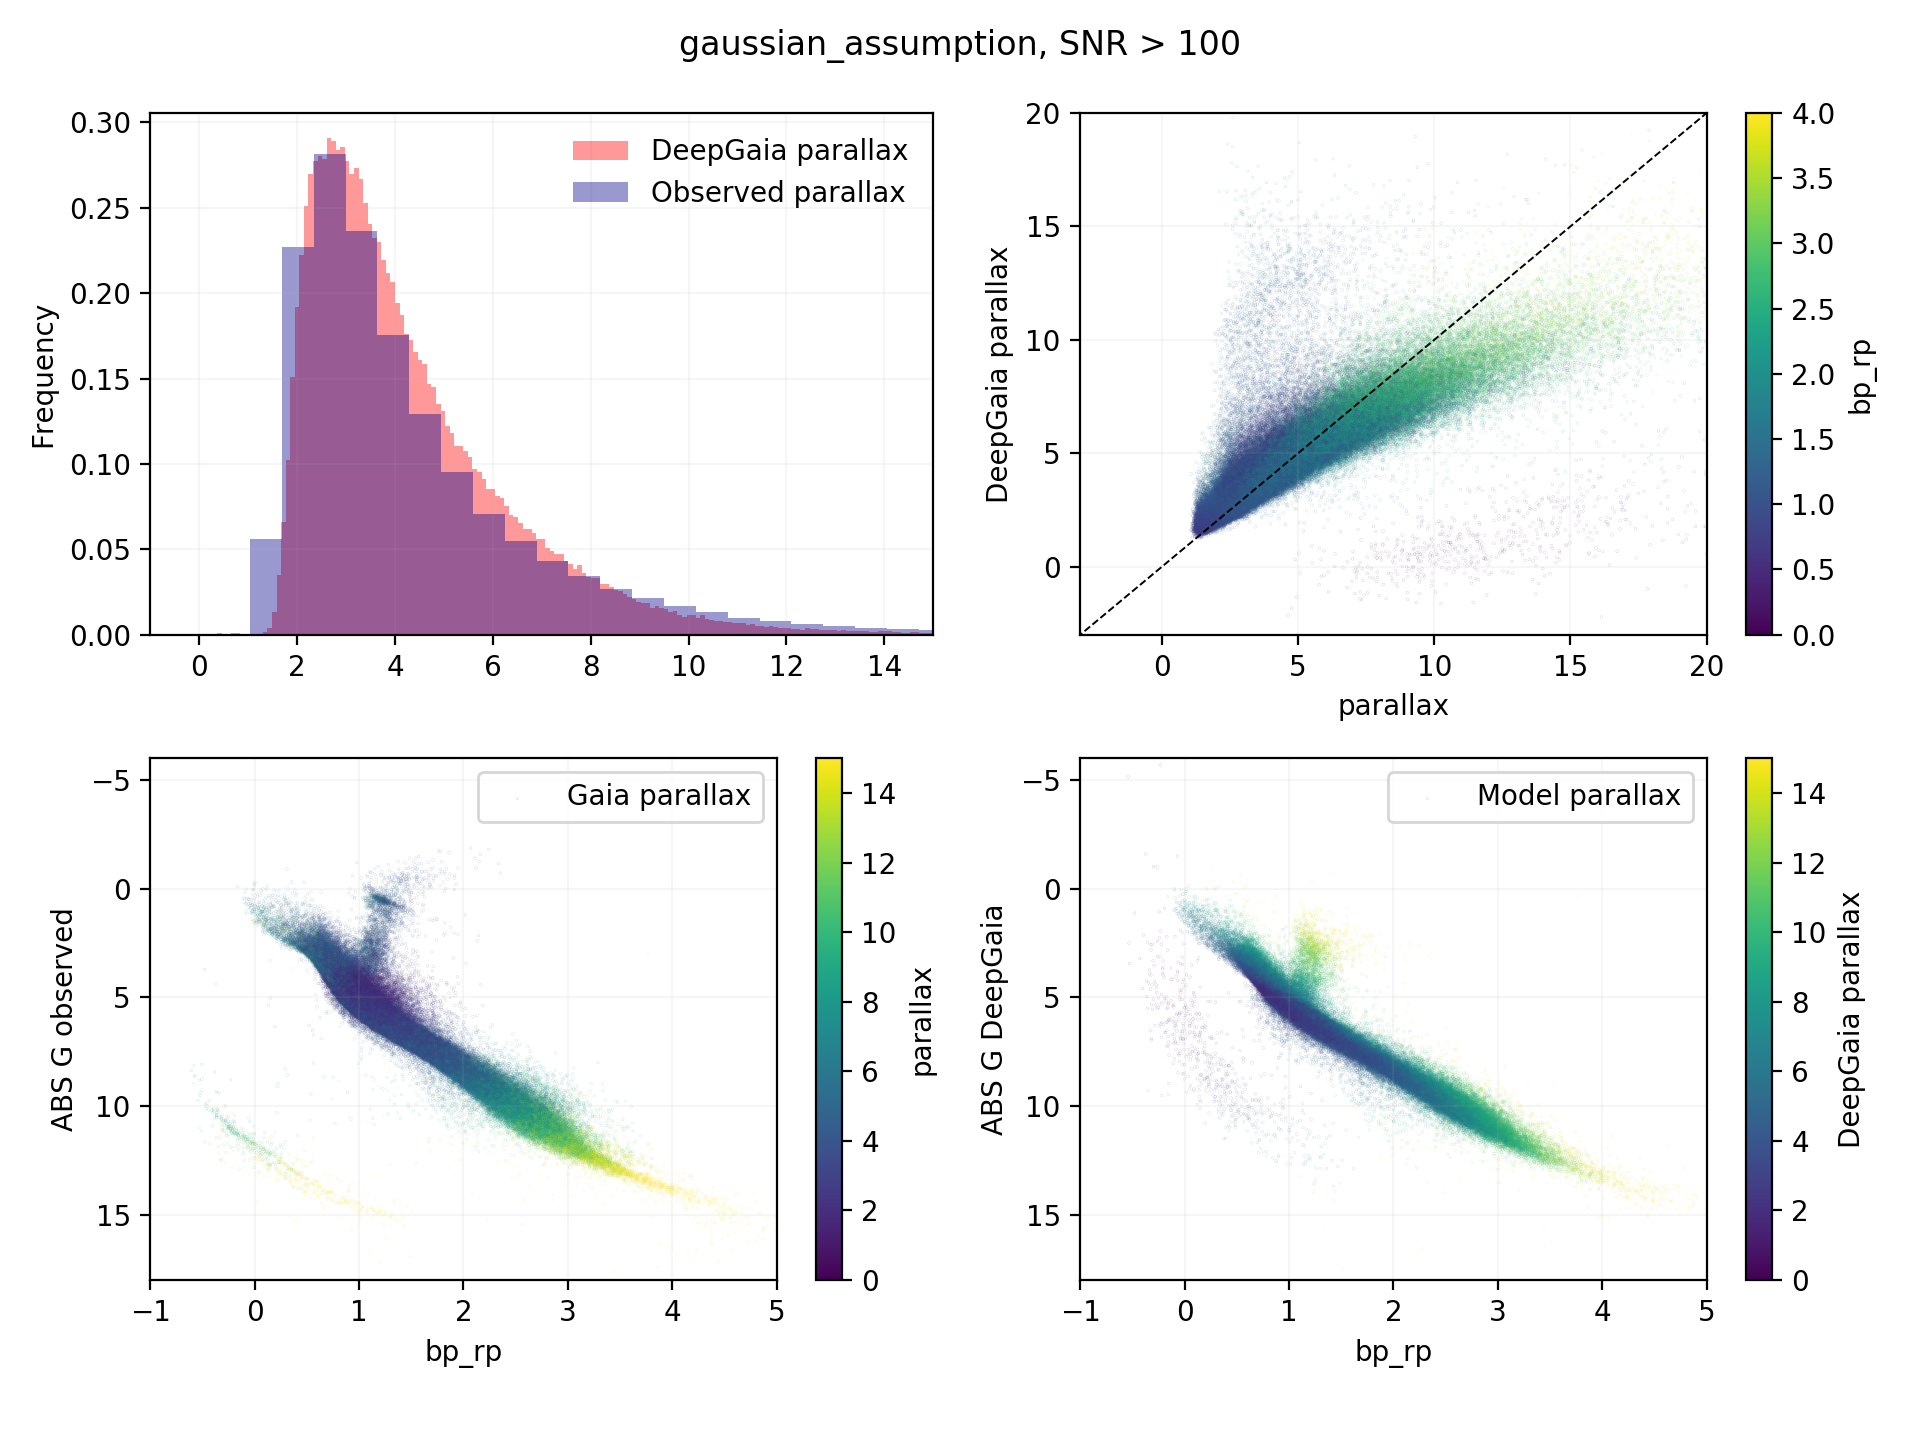

In [24]:
plot_gaia(data_train, 
          sample_size=data_train.shape[0], 
          markersize=0.001, title='{}, SNR > 100'.format(loss_type), 
          max_parallax=15)

<IPython.core.display.Javascript object>


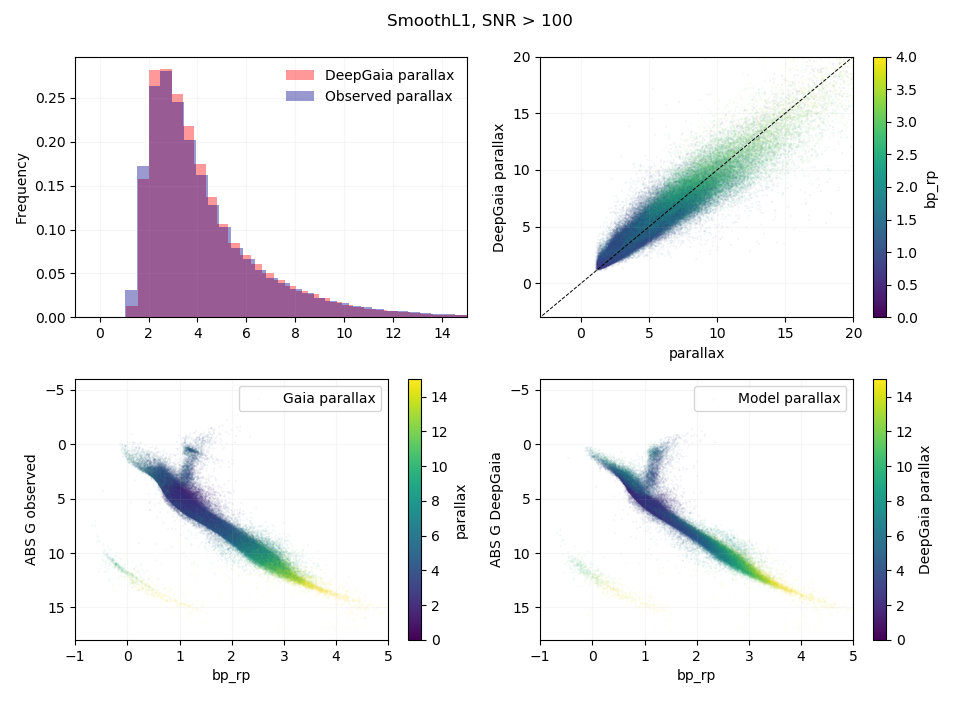

In [20]:
plot_gaia(data_train, 
          sample_size=data_train.shape[0], 
          markersize=0.001, title='{}, SNR > 100'.format(loss_type), 
          max_parallax=15)

--------------- DeepGAIA ---------------

Number of samples used for training: 300000

Features being used for DeepGAIA: ['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'bp_rp', 'bp_g', 'g_rp']


<IPython.core.display.Javascript object>


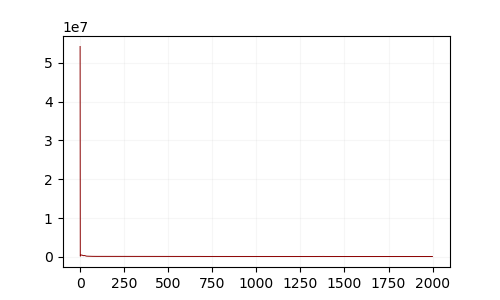

<IPython.core.display.Javascript object>


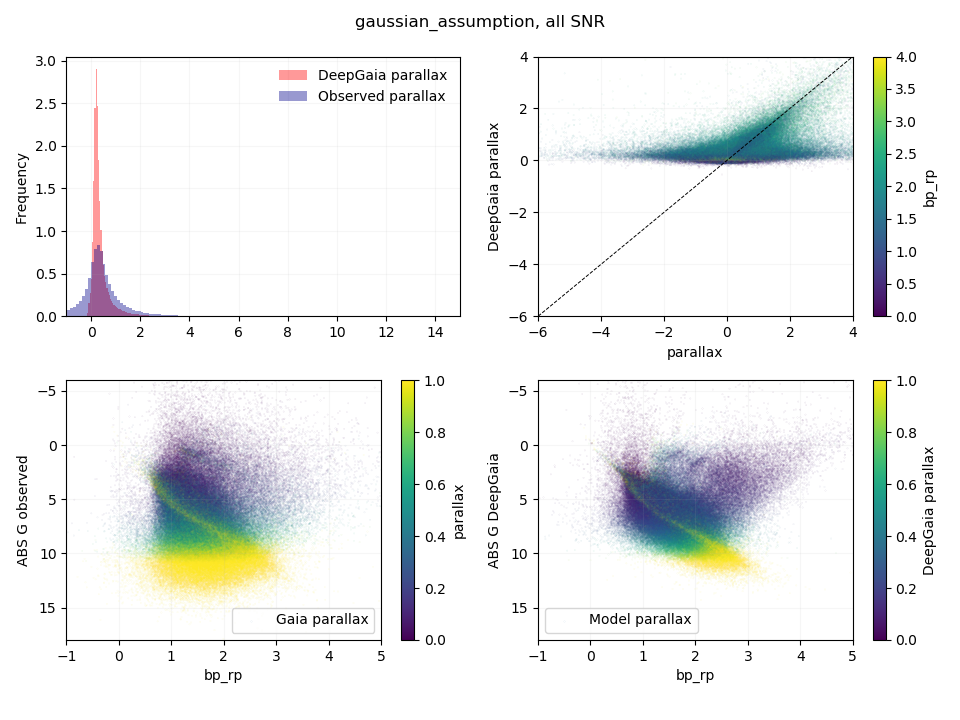

CPU times: user 4min 22s, sys: 1min 49s, total: 6min 11s
Wall time: 6min 4s


In [12]:
%%time

loss_type='gaussian_assumption'

model, data_train = deep_gaia(data_master, n_layers=10, n_nodes=100, n_epochs=2000, 
                              n_samples=300000, loss_type=loss_type)

plot_gaia(data_train, 
          sample_size=data_train.shape[0], 
          markersize=0.001, title='{}, all SNR'.format(loss_type), 
          max_parallax=1)